In [1]:
from functions import *

from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
n = 5
m = RandomIsingModel(n)

In [3]:
def get_proposal_mat_quantum(m, gamma=0.7, t=1):
    '''Get a quantum proposal matrix for a given Ising model.'''
    H_zz = sum([-m.J_rescaled[i,j]*Z(i,n) @ Z(j,n) for i in range(n) for j in range(i+1,n)]) # note that the factor 1/2 is not needed here
    H_z = sum([-m.h_rescaled[i]*Z(i,n) for i in range(n)])
    H_x = sum([X(i,n) for i in range(n)])
    H = (1-gamma) *(H_zz + H_z) + gamma*H_x
    assert np.allclose(H.T, H), 'H must be symmetric.'
    
    proposal_mat = np.zeros((2**m.n, 2**m.n))
    for s in range(2**m.n):
        out_state = sparse_la.expm_multiply(-1j * H * t, get_basis_state(s,m.n))
        transitions = [np.abs(a)**2 for a in out_state]
        proposal_mat[:,s] = transitions

    assert is_stochastic(proposal_mat), 'Proposal matrix is not stochastic.'
    return proposal_mat

In [4]:
num_random_models = 2
num_temperatures = 5
num_gammas = 2
num_times = 2

T_arr = np.geomspace(0.01, 100, num_temperatures)
gammas = np.linspace(0.25, 0.6, num_gammas)
times = np.linspace(2,20,num_times)

delta_random_arr = np.zeros((num_temperatures, num_random_models))
delta_local_arr = np.zeros((num_temperatures, num_random_models))
delta_quantum_arr = np.zeros((num_temperatures, num_random_models, num_gammas, num_times))

# Parallelize for-loop
def process_data_train(T_index):
    T = T_arr[T_index]

    _delta_random_arr = np.zeros((num_random_models))
    _delta_local_arr = np.zeros((num_random_models))
    _delta_quantum_arr = np.zeros((num_random_models, num_gammas, num_times))

    for i in range(num_random_models):
        m = RandomIsingModel(n)

        proposal_mat_random = get_proposal_mat_random(m)
        P_random = get_transition_matrix(m, T, proposal_mat_random)
        delta_random = get_delta(P_random)
        _delta_random_arr[i] = delta_random

        proposal_mat_local = get_proposal_mat_local(m)
        P_local = get_transition_matrix(m, T, proposal_mat_local)
        delta_local = get_delta(P_local)
        _delta_local_arr[i] = delta_local
    
        for gamma_index in range(num_gammas):
            gamma = gammas[gamma_index]
            for time_index in range(num_times):
                t = times[time_index]
                proposal_mat_quantum = get_proposal_mat_quantum(m, gamma=gamma, t=t)
                P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
                delta_quantum = get_delta(P_quantum)
                _delta_quantum_arr[i][gamma_index][time_index] = delta_quantum

        return [_delta_random_arr, _delta_local_arr, _delta_quantum_arr]

In [6]:
arr = Parallel(n_jobs=-1, verbose=3)(delayed(process_data_train)(T_index) for T_index in range(num_temperatures))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.0s finished


In [ ]:
# num_random_models = 5
# num_temperatures = 10
# num_gammas = 5
# num_times = 5

# T_arr = np.geomspace(0.01, 100, num_temperatures)
# gammas = np.linspace(0.25, 0.6, num_gammas)
# times = np.linspace(2,20,num_times)

# delta_random_arr = np.zeros((num_temperatures, num_random_models))
# delta_local_arr = np.zeros((num_temperatures, num_random_models))
# delta_quantum_arr = np.zeros((num_temperatures, num_random_models, num_gammas, num_times))

# for T_index in tqdm(range(num_temperatures)):
#     T = T_arr[T_index]
#     for i in range(num_random_models):
#         m = RandomIsingModel(n)

#         proposal_mat_random = get_proposal_mat_random(m)
#         P_random = get_transition_matrix(m, T, proposal_mat_random)
#         delta_random = get_delta(P_random)
#         delta_random_arr[T_index][i] = delta_random

#         proposal_mat_local = get_proposal_mat_local(m)
#         P_local = get_transition_matrix(m, T, proposal_mat_local)
#         delta_local = get_delta(P_local)
#         delta_local_arr[T_index][i] = delta_local
    
#         for gamma_index in range(num_gammas):
#             gamma = gammas[gamma_index]
#             for time_index in range(num_times):
#                 t = times[time_index]
#                 proposal_mat_quantum = get_proposal_mat_quantum(m, gamma=gamma, t=t)
#                 P_quantum = get_transition_matrix(m, T, proposal_mat_quantum)
#                 delta_quantum = get_delta(P_quantum)
#                 delta_quantum_arr[T_index][i][gamma_index][time_index] = delta_quantum

100%|██████████| 10/10 [10:51<00:00, 65.15s/it]


In [ ]:
delta_random_arr_avg = np.mean(delta_random_arr, axis=1)
delta_random_arr_std = np.std(delta_random_arr, axis=1)

delta_local_arr_avg = np.mean(delta_local_arr, axis=1)
delta_local_arr_std = np.std(delta_local_arr, axis=1)

delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=(1,2,3))
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=(1,2,3))

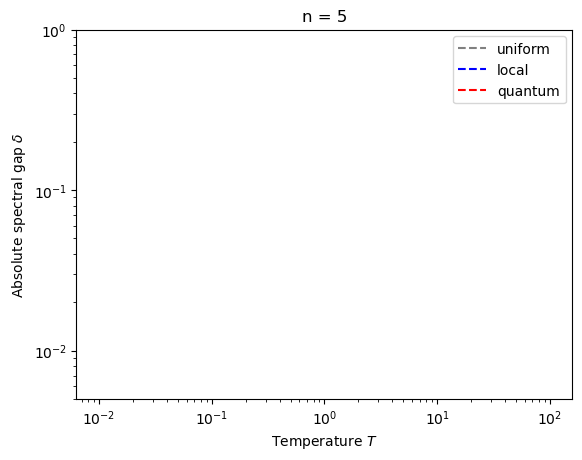

In [ ]:
plt.plot(T_arr, delta_random_arr_avg, '--', color='grey', label = 'uniform')
plt.plot(T_arr, delta_local_arr_avg, '--', color='blue', label = 'local')
plt.plot(T_arr, delta_quantum_arr_avg, '--', color='red', label = 'quantum')

plt.fill_between(T_arr, 
                 delta_random_arr_avg-delta_random_arr_std, 
                 delta_random_arr_avg+delta_random_arr_std, 
                 color='grey',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_local_arr_avg-delta_local_arr_std, 
                 delta_local_arr_avg+delta_local_arr_std, 
                 color='blue',
                 alpha=0.1)
plt.fill_between(T_arr, 
                 delta_quantum_arr_avg-delta_quantum_arr_std, 
                 delta_quantum_arr_avg+delta_quantum_arr_std, 
                 color='red',
                 alpha=0.1)

plt.title(f'n = {n}')
plt.xlabel('Temperature $T$')
plt.ylabel('Absolute spectral gap $\delta$')
plt.ylim(0.005, 1)
plt.yscale('log')
plt.xscale('log')
plt.legend()